# Tree Cover from MODIS Data

Generate MODIS tree cover map for the US, lower 48 from the MOD44B dataset for 2016. The data for this work can be found in ADAPT under /css/modis/Collection6/L3/MOD44B-VCF/2016/065. Looks like there are a total of 291 files.

Requirements:
- All together in the native projection
- All together in lat-long projection (geographic)
- Tell me what you did, how and why, questions

Installation requirements: conda install GDAL, pip install rasterio --force-reinstall --no-binary rasterio <br/>
Author: Jordan A. Caraballo-Vega <jorda.a.caraballo-vega@nasa.gov> <br/>
Version: 0.0.1

In [1]:
import os
from datetime import datetime
from glob import glob
import numpy as np
import xarray as xr
import rioxarray as rxr
import cupy as cp
import matplotlib.pyplot as plt
from matplotlib import colors
import ipywidgets as widgets
import multiprocessing as mp

print("Number of processors: ", mp.cpu_count())

Number of processors:  40


In [2]:
# Test filename to work with in the meantime
data_path = '/css/modis/Collection6/L3/MOD44B-VCF/2006/065/MOD44B.A2006065'
tiles = ['h08v04', 'h09v04', 'h10v04', 'h11v04', 'h12v04', 'h08v05', 'h09v05', 'h10v05', 'h11v05', 'h12v05', 'h08v06', 'h09v06','h10v06']

In [3]:
filenames = list()
for t in tiles:
    filenames = filenames + glob(f'{data_path}.{t}.*')

In [4]:
# Read single file for now
datasets_list = list()
for fds in filenames:
    datasets_list.append(rxr.open_rasterio(fds))

In [5]:
from rioxarray.merge import merge_datasets
merged = merge_datasets(datasets_list)
merged

<xarray.Dataset>
Dimensions:                     (band: 1, x: 24000, y: 14401)
Coordinates:
  * band                        (band) int64 1
  * x                           (x) float64 -1.112e+07 -1.112e+07 ... -5.56e+06
  * y                           (y) float64 5.56e+06 5.559e+06 ... 2.224e+06
    spatial_ref                 int64 0
Data variables:
    Percent_Tree_Cover          (band, y, x) uint8 200 200 200 200 ... 0 0 0 0
    Percent_NonTree_Vegetation  (band, y, x) uint8 200 200 200 200 ... 0 0 0 0
    Percent_NonVegetated        (band, y, x) uint8 200 200 200 200 ... 0 0 0 0
    Quality                     (band, y, x) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    Percent_Tree_Cover_SD       (band, y, x) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    Percent_NonVegetated_SD     (band, y, x) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    Cloud                       (band, y, x) uint8 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes: (12/49)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:      MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:        Terra
    ASSOCIATEDSENSORSHORTNAME.1:          MODIS
    AUTOMATICQUALITYFLAG.1:               Passed
    AUTOMATICQUALITYFLAGEXPLANATION.1:    set Passed as default, will decide ...
    DAYNIGHTFLAG:                         Day
    ...                                   ...
    SHORTNAME:                            MOD44B
    SOUTHBOUNDINGCOORDINATE:              39.9999999964079
    TileID:                               51008004
    VERSIONID:                            6
    VERTICALTILENUMBER:                   4
    WESTBOUNDINGCOORDINATE:               -155.572382657541

## Open MODIS dataset with GDAL and XARRAY

In the Collection 6 release of the MODIS VCF product (MOD44B) there are 7 science data sets (SDSs): 1) percent tree cover; 2) percent non-tree vegetation; 3) percent non-vegetated; 4) quality; 5) percent tree cover standard deviation (SD); 6) percent non-vegetated standard deviation (SD); and 7) cloud. The first three layers listed are the primary data layers with the remaining 4 layers providing the user with indications of the overall quality of the data for any
given pixel.

In [6]:
# modis_template_layers = 'HDF4_EOS:EOS_GRID:"%s":MOD44B_250m_GRID:%s'  # template from MODIS product
# modis_selected_layers = ['Percent_Tree_Cover']  # modis layers to utilize
lat_long_projection = "EPSG:4326"
merged = merged.rio.reproject(lat_long_projection)

In [7]:
tree_cover = merged['Percent_Tree_Cover']
print(tree_cover.min().values, tree_cover.max().values, tree_cover.shape)

0 255 (1, 7872, 26859)


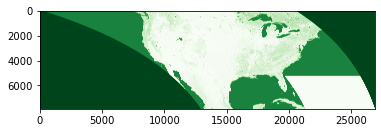

In [8]:
plt.imshow(np.squeeze(tree_cover.values), cmap='Greens')
plt.show()

In [9]:
tree_cover

<xarray.DataArray 'Percent_Tree_Cover' (band: 1, y: 7872, x: 26859)>
array([[[255, 255, 200, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ...,   0,   0, 255],
        [255, 255, 255, ...,   0,   0,   0],
        [255, 255, 255, ...,   0,   0,   0]]], dtype=uint8)
Coordinates:
  * x            (x) float64 -155.6 -155.6 -155.6 ... -53.22 -53.21 -53.21
  * y            (y) float64 50.0 49.99 49.99 49.99 ... 20.01 20.01 20.0 20.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255

In [10]:
# reproject and output file
tree_cover.rio.reproject(lat_long_projection).rio.to_raster("modis_tree_cover_test.tif")
tree_cover.isel(band=0).rio.to_raster("modis_tree_cover_test_isel.tif", compress='LZW')